# Evaluting timing of the WEP pipeline on USDF

Owner: Bryce Kalmbach ([@jbkalmbach)](https://github.com/lsst-ts/ts_aos_analysis/issues/new?body=@jbkalmbach)

Last Verified to Run: 2024-08-22

Software Versions:
* `lsst_distrib`: **w_2024_32**

Requirements:
* `lsst_distrib`
* `ts_aos_analysis`

## Notebook Objective
This notebook calculates the timing to run the AOS Wavefront Estimation Pipeline (WEP).
We evaluate the timing based upon the information stored in the butler metadata as each task runs.

## Logistics
This notebook as written can be run on USDF using the AOS butler at `/sdf/data/rubin/repo/aos_imsim/`. 
You will need to change the repo directory if you want to access the timing of the pipeline in other USDF repos or on the summit. 
To do so change the `butler_path` and `collection_name` variables below accordingly.

## Imports

In [1]:
import numpy as np
from lsst.daf.butler import Butler
from astropy.time import Time
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

In [2]:
from lsst.ts.aos.analysis import get_task_metadata, get_timing_from_metadata

## Load Test Data

In [3]:
butler_path = '/sdf/data/rubin/repo/aos_imsim/'
collection_name = 'sitcomtn-135/directDetectTimingTest_SourceLimit5'

Specify the exposures and detector IDs in the list below based upon the data and instrument upon which the pipeline ran.

In [4]:
exposure_list = [7024072600012, 7024072600010]
detector_list = np.arange(9) # ComCam Detectors

In [5]:
# If you ran the pipeline with additional aggregate and plotting tasks uncomment required tasks
task_list = [
    "isr",
    "generateDonutDirectDetectTask",
    # "aggregateDonutCatalogsTask",
    "cutOutDonutsScienceSensorTask",
    # "aggregateDonutStampsTask",
    # "plotDonutTask",
    "calcZernikesTask",
    # "aggregateZernikesTask",
    # "aggregateAOSVisitTableTask",
    # "plotAOSTask",
]

In [6]:
# If you ran the pipeline with additional aggregate and plotting tasks uncomment required tasks
colors = {
    'isr': 'k',
    'generateDonutDirectDetectTask': 'r',
    # 'aggregateDonutCatalogsTask': 'g',
    'cutOutDonutsScienceSensorTask': 'b',
    # 'aggregateDonutStampsTask': 'c',
    # 'plotDonutTask': 'm',
    'calcZernikesTask': 'y',
    # 'aggregateZernikesTask': 'orange',
    # 'aggregateAOSVisitTableTask': 'gray',
    # 'plotAOSTask': 'pink'
}

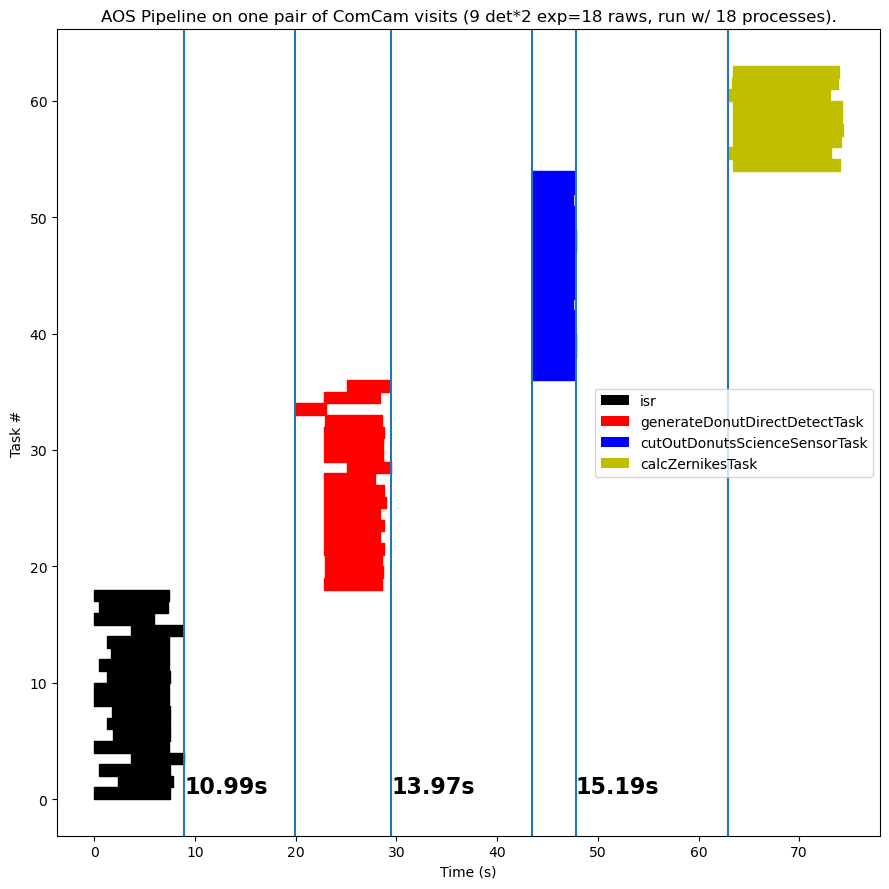

In [7]:
task_metadata = get_task_metadata(butler_path, collection_name, task_list, exposure_list, detector_list)
jobs, first_job, last_job, longest_job_5_donuts = get_timing_from_metadata(task_metadata)
t0 = Time(min(j[1] for j in jobs)[:-6]).mjd

# Plot
plt.figure(figsize=(9,9))

for ijob, job in enumerate(jobs):
    start = (Time(job[1][:-6]).mjd-t0) * 86400
    end = (Time(job[2][:-6]).mjd-t0) * 86400
    plt.fill_between([start, end], ijob, ijob+1, color=colors[job[0]])

# Create custom legend
legend_elements = []
for k, v in colors.items():
    legend_elements.append(
        Patch(facecolor=v, label=k)
    )

# Calculate time between tasks
for first, last in zip(first_job[1:], last_job[:-1]):
    start = (Time(first[:-6]).mjd-t0) * 86400
    end = (Time(last[:-6]).mjd-t0) * 86400
    plt.axvline(start)
    plt.axvline(end)
    plt.text(end, 0.5, f'{(start-end):.2f}s', size=16, weight='bold')
    
# Add the legend to the plot
plt.legend(handles=legend_elements,)
plt.xlabel("Time (s)")
plt.ylabel("Task #")
plt.title('AOS Pipeline on one pair of ComCam visits (9 det*2 exp=18 raws, run w/ 18 processes).')
plt.tight_layout()

Text(0.5, 1.0, 'Expected Maximum Runtime per Task Type')

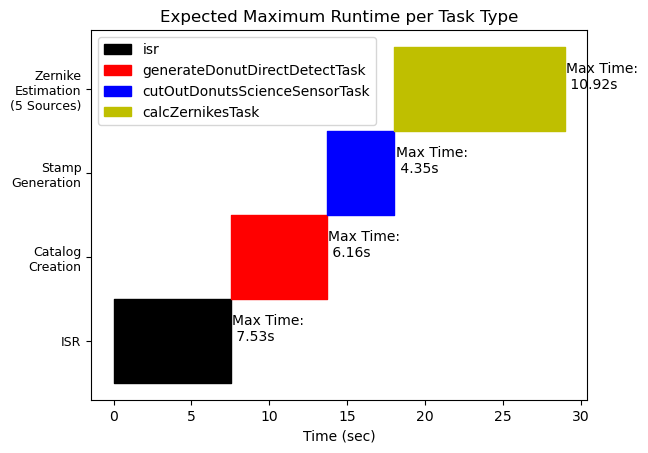

In [8]:
fig = plt.figure()
t_start = 0
i = 0
for job_time, task in zip(longest_job_5_donuts, task_list):
    plt.fill_between([t_start, t_start+job_time], i, i+1, color=colors[task], label=task)
    t_start += job_time
    plt.text(t_start + 0.1, i+0.5, f"Max Time:\n {job_time:.2f}s")
    i += 1
plt.yticks([0.5, 1.5, 2.5, 3.5], ['ISR', 'Catalog\nCreation', 'Stamp\nGeneration', 'Zernike\nEstimation\n(5 Sources)'], size=9)
plt.legend()
plt.xlabel('Time (sec)')
plt.title('Expected Maximum Runtime per Task Type')